In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
from numpy.random import multivariate_normal as mvn, normal as normal
from scipy.optimize import minimize
from utils import StellarAndPlanetGP, QuasiPeriodicKernel, MultiQuasiPeriodicKernel
import pandas as pd
from sklearn.preprocessing import StandardScaler
import corner
import radvel
from scipy import optimize

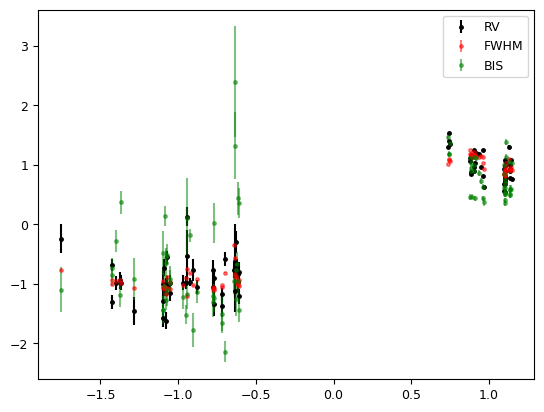

In [2]:
data = pd.read_csv(
    '../../data/ex2_RVs.txt',
    sep=',',
    header=None,
    names=['time', 'radial_velocity', 'radial_velocity_uncertainty', 'FWHM_CCF',
           'FWHM_CCF_uncertainty', 'BIS', 'BIS_uncertainty', 'instrument'],
    skiprows=8,
)

# data = data[~data['instrument'].isin(['INST1'])]

time_scaler = StandardScaler()
rv_scaler = StandardScaler()
fwhm_scaler = StandardScaler()
bis_scaler = StandardScaler()
y_scalers = [rv_scaler, fwhm_scaler, bis_scaler]

time = data['time'].values
rv = data['radial_velocity'].values
rv_err = data['radial_velocity_uncertainty'].values
fwhm = data['FWHM_CCF'].values
fwhm_err = data['FWHM_CCF_uncertainty'].values
bis = data['BIS'].values
bis_err = data['BIS_uncertainty'].values

time = time_scaler.fit_transform(time.reshape(-1, 1)).ravel()
rv = rv_scaler.fit_transform(rv.reshape(-1, 1)).ravel()
rv_err = (rv_err / rv_scaler.scale_).ravel()
fwhm = fwhm_scaler.fit_transform(fwhm.reshape(-1, 1)).ravel()
fwhm_err = (fwhm_err / fwhm_scaler.scale_).ravel()
bis = bis_scaler.fit_transform(bis.reshape(-1, 1)).ravel()
bis_err = (bis_err / bis_scaler.scale_).ravel()

y = np.vstack([rv, fwhm, bis]).T
y_err = np.vstack([rv_err, fwhm_err, bis_err]).T

plt.errorbar(time, y[:, 0], yerr=y_err[:, 0], fmt='k.', label='RV')
plt.errorbar(time, y[:, 1], yerr=y_err[:, 1], fmt='r.', label='FWHM', alpha=0.5)
plt.errorbar(time, y[:, 2], yerr=y_err[:, 2], fmt='g.', label='BIS', alpha=0.5)
plt.legend()

In [3]:
gp = StellarAndPlanetGP(time, y, y_err, num_planets=0)
gp.params_keys

['stellar_amp',
 'fwhm_amp',
 'bis_amp',
 'stellar_P',
 'stellar_lsp',
 'stellar_lse']

In [4]:
((31, 10) / time_scaler.scale_)

array([0.01412833, 0.00455753])

In [12]:
sampler = gp.run_mcmc(
    uniform_priors={
        'stellar_amp': (1e-4, 2),
        'fwhm_amp': (1e-4, 2),
        'bis_amp': (1e-4, 2),
        'stellar_lsp': (1e-4, 5),
        'stellar_lse': (1e-4, 2)
    },
    gaussian_priors={
        'stellar_P': ((31, 10) / time_scaler.scale_)
    },
    nwalkers=100,
    niterations=1000
)

100%|██████████| 1000/1000 [02:32<00:00,  6.57it/s]


In [27]:
burn_in = 100
thin = 10
log_prob_samples = sampler.get_log_prob(discard=burn_in, thin=thin, flat=True)
samples = sampler.get_chain(discard=burn_in, thin=thin, flat=True)
best_fit_params = samples[np.argmax(log_prob_samples)]
best_fit_params

array([0.71016058, 0.61305867, 1.07853441, 0.01614561, 4.71154431,
       0.27605674])

In [19]:
# Extract the samples
samples = sampler.get_chain(discard=100, thin=10, flat=True)
# samples[:, 0] = rv_scaler.inverse_transform(samples[:, 0].reshape(-1, 1)).ravel()
# samples[:, 1] = fwhm_scaler.inverse_transform(samples[:, 1].reshape(-1, 1)).ravel()
# samples[:, 2] = bis_scaler.inverse_transform(samples[:, 2].reshape(-1, 1)).ravel()
# samples[:, 3] = samples[:, 3] * time_scaler.scale_
# samples[:, 4] = samples[:, 4] * time_scaler.scale_
# samples[:, 5] = samples[:, 5] * time_scaler.scale_

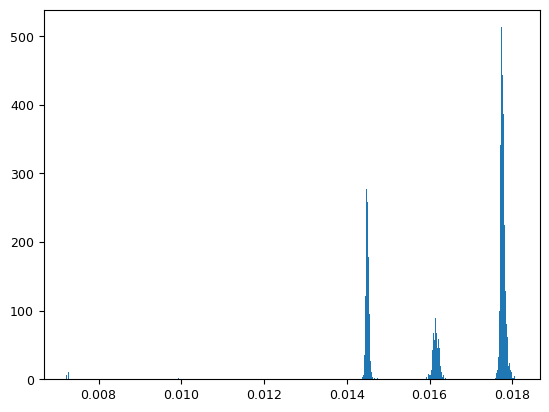

In [20]:
plt.hist(samples[:, 3], bins=1000)
plt.show()

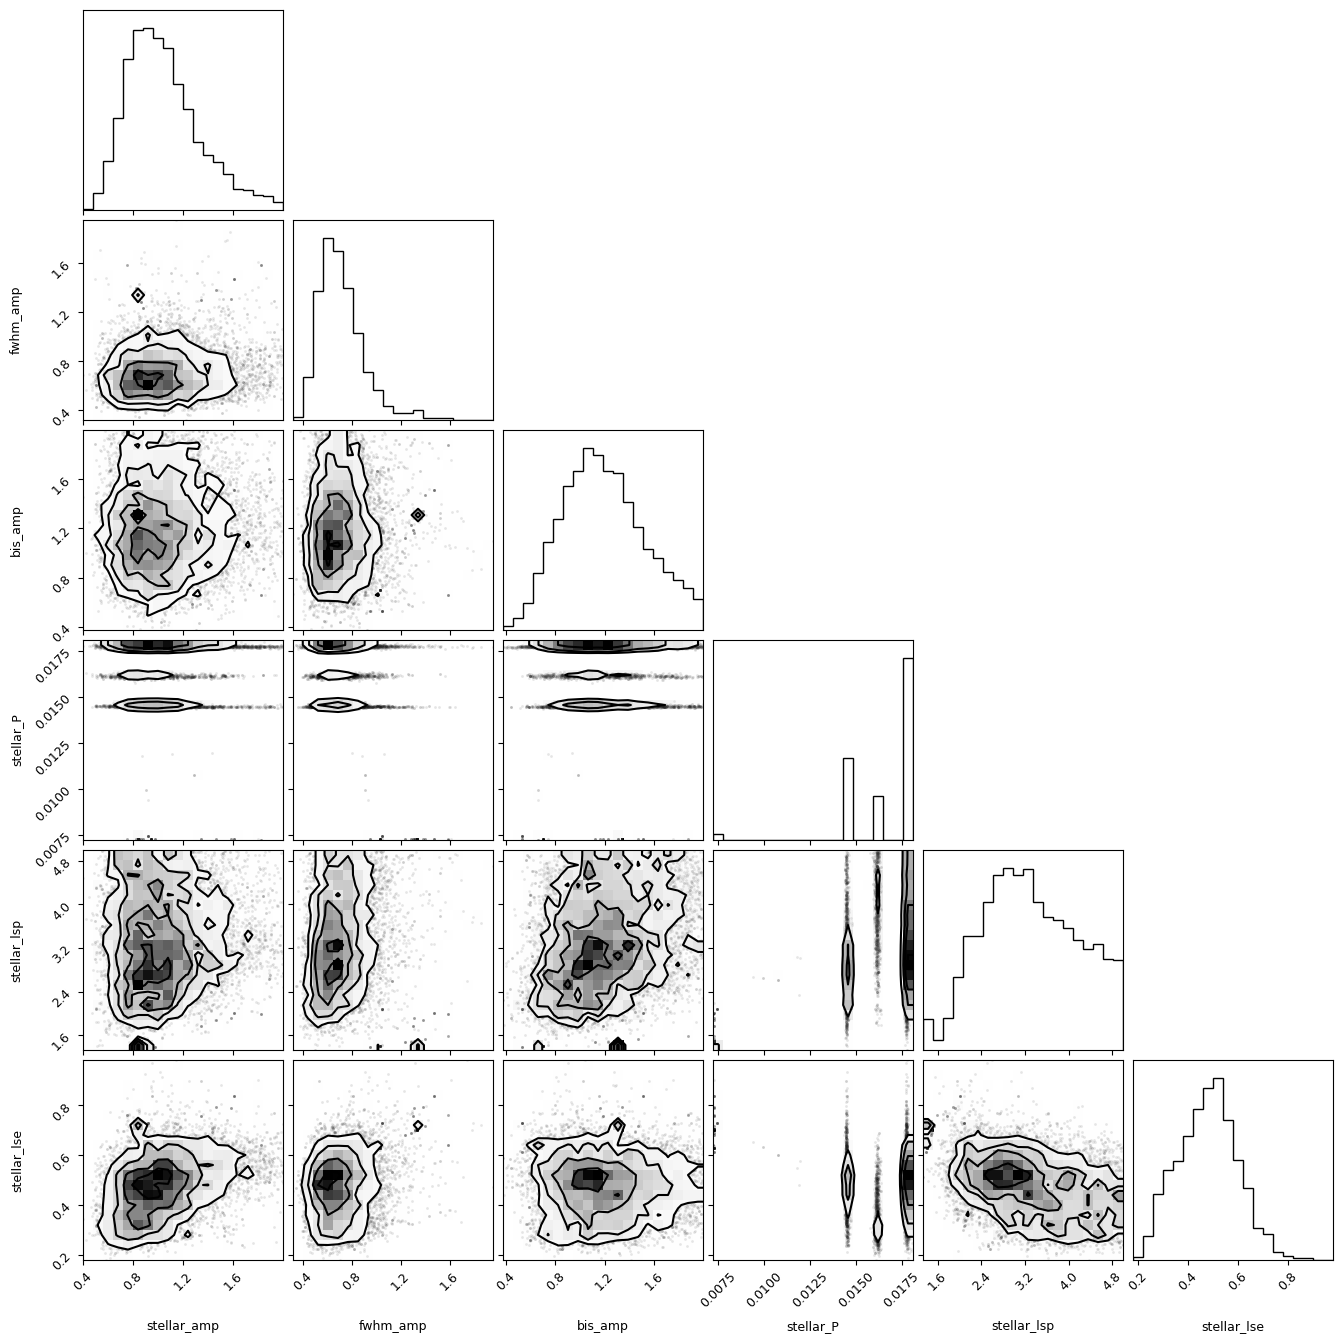

In [21]:
labels = gp.params_keys
figure = corner.corner(samples, labels=labels, truths=None)
# axes = np.array(figure.axes).reshape((6, 6))
# axes[3, 3].set_xlim(0, 50)
plt.show()

In [5]:
def triple_plot(kernels, time, y, y_err, time_scaler, y_scalers):
    t_linspace = np.linspace(time.min(), time.max(), 1400)

    posteriors = []

    for i, kernel in enumerate(kernels):
        kernel.compute_kernel(time, time, y_err[:, i]).compute_loglikelihood(y[:, i])
        print(-kernel.loglikelihood)
        mu_post, cov_post = kernel.compute_posterior(t_linspace)
        posteriors.append((mu_post, cov_post))

    # Plot the results
    fig = plt.figure(figsize=(14, 14))
    
    titles = ['RV', 'FWHM', 'BIS']
    y_label = 'RV ($m s^{-1}$)'
    x_label = 'Time (BJD)'
    
    for i, (mu_post, cov_post) in enumerate(posteriors):
        std_post = np.sqrt(np.diag(cov_post))
        plt.subplot(3, 1, i+1)
    
        plt.errorbar(
            time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform(y[:, i].reshape(-1, 1)).ravel(), 
            yerr=y_err[:, i] * y_scalers[i].scale_, 
            fmt='kx', label=f'{titles[i]} training data'
        )

        plt.plot(
            time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform(mu_post.reshape(-1, 1)), 
            'b', label=f'GP Mean'
        )

        plt.fill_between(
            time_scaler.inverse_transform(t_linspace.reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform((mu_post - 2*std_post).reshape(-1, 1)).ravel(), 
            y_scalers[i].inverse_transform((mu_post + 2*std_post).reshape(-1, 1)).ravel(), 
            color='blue', alpha=0.2, label='Confidence interval (±2 std)'
        )
        
        # plt.errorbar(
        #     time, 
        #     y[:, i], 
        #     yerr=y_err[:, i], 
        #     fmt='kx', label=f'{titles[i]} training data'
        # )
        # 
        # plt.plot(
        #     t_linspace, 
        #     mu_post, 
        #     'b', label=f'GP Mean'
        # )
        # 
        # plt.fill_between(
        #     t_linspace, 
        #     mu_post - 2*std_post, 
        #     mu_post + 2*std_post, 
        #     color='blue', alpha=0.2, label='Confidence interval (±2 std)'
        # )
        
        
        plt.margins(x=0.01)
    
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(titles[i])

    plt.tight_layout()
    return fig
    
def residual_plot(kernel, time, rv, rv_err, time_scaler):
    kernel.compute_kernel(time, time, rv_err).compute_loglikelihood(rv)
    print(kernel.loglikelihood)
    mu_post, cov_post = kernel.compute_posterior(time)


    # Plot the results
    plt.figure(figsize=(6, 4))
    
    std_post = np.sqrt(np.diag(cov_post))
    residuals = rv - mu_post
    normalised_residuals = residuals / std_post
    
    plt.errorbar(
        time_scaler.inverse_transform(time.reshape(-1, 1)).ravel(),
        residuals,
        rv_err,
        fmt='o'
    )

    plt.margins(x=0.01)
    x_label = 'Time (BJD)'
    plt.xlabel('Time (BJD)')
    plt.ylabel('Normalised Residuals')

    plt.tight_layout()
    plt.show()
    

0.017749461510567003 [38.94539394]
14.60149263395703
-57.419223663220464
56.91369735917139
{'stellar_amp': 0.9979332935520244, 'fwhm_amp': 0.5797644658693691, 'bis_amp': 0.9610098686193651, 'stellar_P': 0.017749461510567003, 'stellar_lsp': 2.592970108216714, 'stellar_lse': 0.509357680044431}


<Axes: title={'center': 'RV'}, xlabel='Time (BJD)', ylabel='RV ($m s^{-1}$)'>

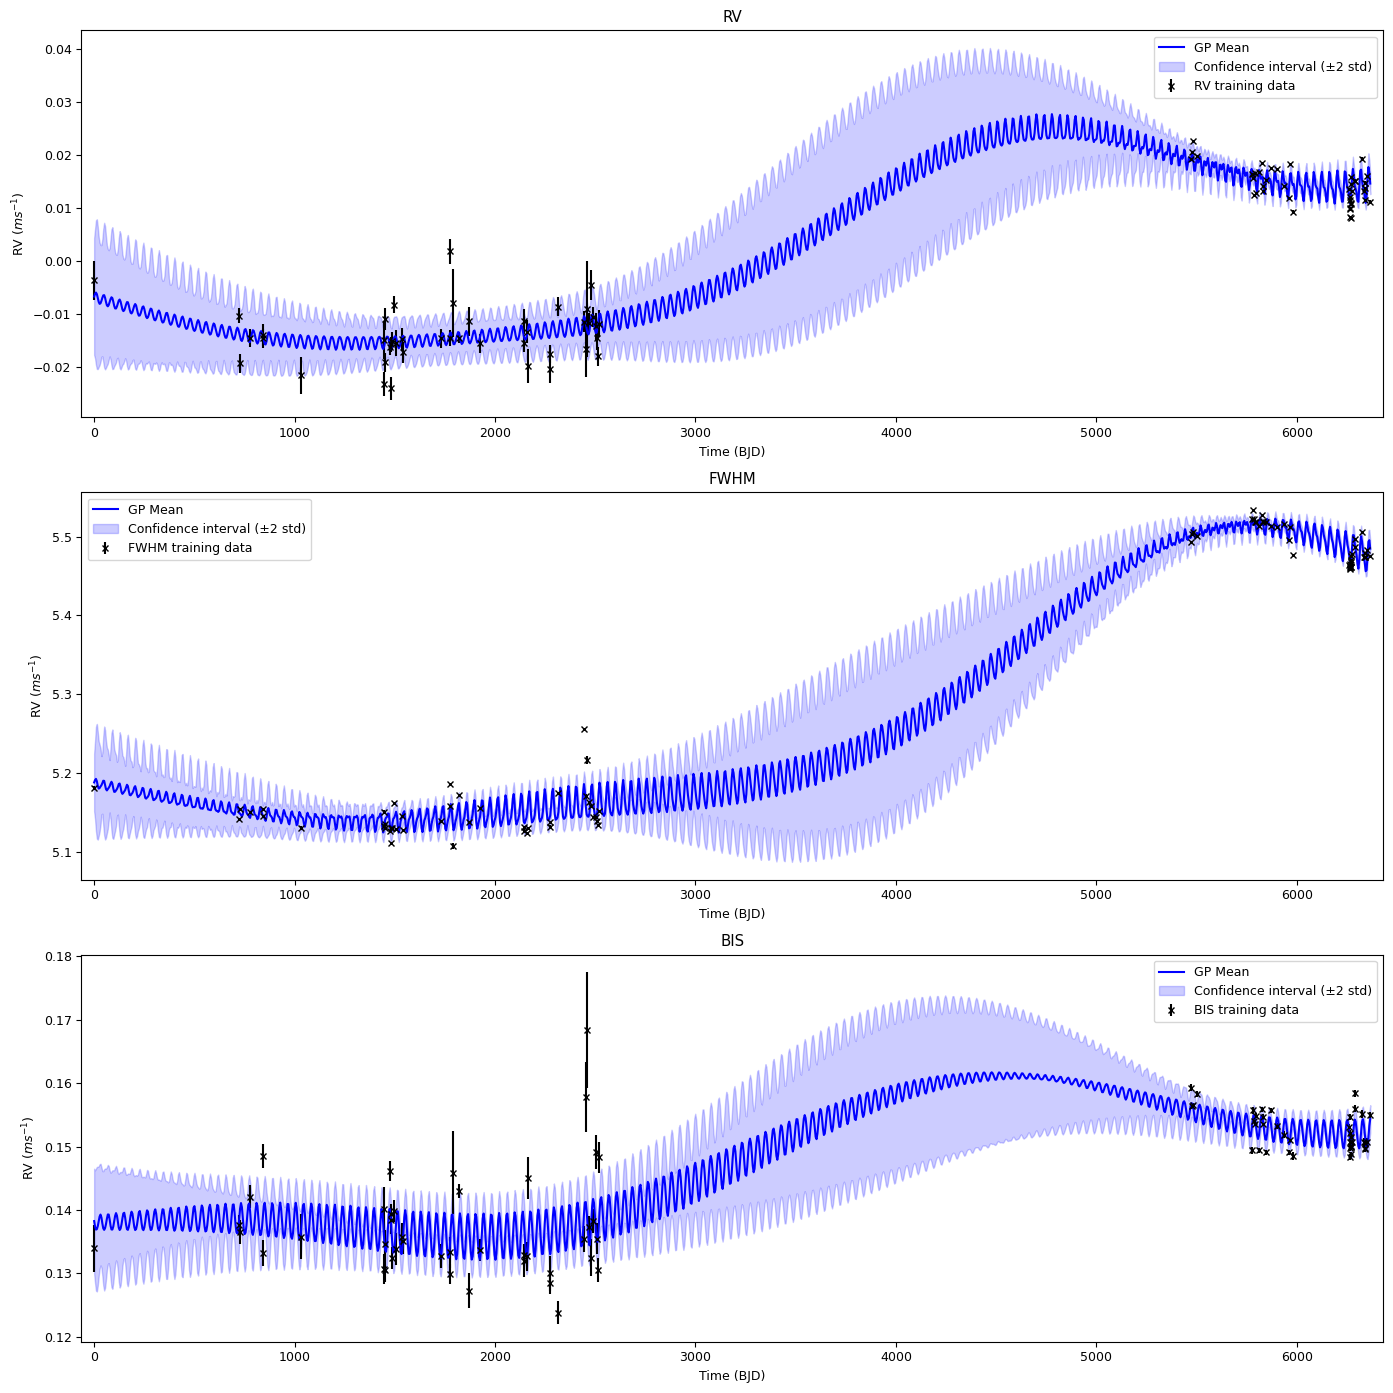

In [6]:
np.random.seed(45)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=0)
result = gp.fit(
    # initial_theta={key: 1.0 for key in gp.params_keys},
    bounds={'stellar_P': (21, 41) / time_scaler.scale_},
    # initial_theta={'stellar_amp': 20}
)
print(gp.model_params['stellar_P'], gp.model_params['stellar_P'] * time_scaler.scale_)
fig = triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)
# plt.savefig('./0planets.png')
# plt.show()
print(gp.model_params)
plt.subplot(3, 1, 1)

In [ ]:
np.random.seed(45)
stellar_gp = MultiQuasiPeriodicKernel

-14.60149263395703


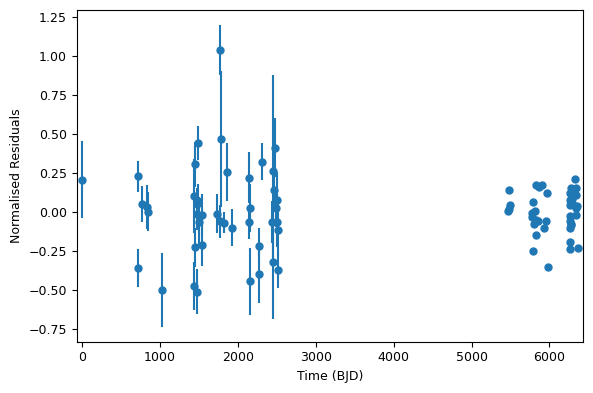

In [26]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)

In [28]:
sampler = gp.run_mcmc(
    nwalkers=1000, niterations=500, 
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}, 
    initial_theta={key: value for key, value in zip(gp.model_params.keys(), result.x)}
)

100%|██████████| 500/500 [04:46<00:00,  1.75it/s]


In [ ]:
# Extract the samples
samples = sampler.get_chain(discard=200, thin=10, flat=True)
samples[:, 0] = rv_scaler.inverse_transform(samples[:, 0].reshape(-1, 1)).ravel()
samples[:, 1] = fwhm_scaler.inverse_transform(samples[:, 1].reshape(-1, 1)).ravel()
samples[:, 2] = bis_scaler.inverse_transform(samples[:, 2].reshape(-1, 1)).ravel()
samples[:, 3] = samples[:, 3] * time_scaler.scale_
samples[:, 4] = samples[:, 4] * time_scaler.scale_
samples[:, 5] = samples[:, 5] * time_scaler.scale_

In [ ]:
plt.hist(samples[:, 3], bins=50, range=(32, 40))
plt.show()

In [ ]:
labels = gp.params_keys
figure = corner.corner(samples, labels=labels, truths=None, ranges=[
    None, None, None, (100, 101), None, None
])
# axes = np.array(figure.axes).reshape((6, 6))
# axes[3, 3].set_xlim(0, 50)
# plt.savefig('./0planets_corner.png')
plt.show()

<ErrorbarContainer object of 3 artists>

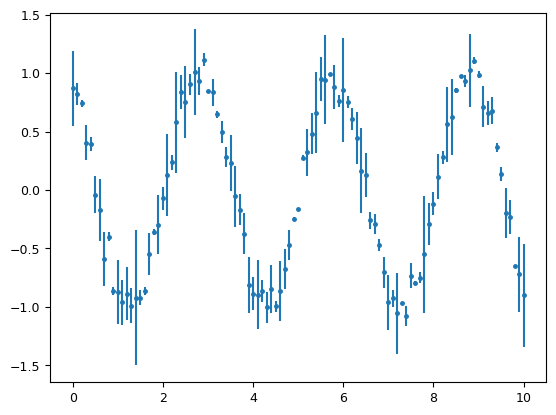

In [263]:
def sin_wave(x, amplitude, period, phase_offset):
    return amplitude * np.sin((x/period)*2*np.pi + phase_offset)

def negative_log_likelihood(theta, x, y, y_err):
    log_likelihood = (sin_wave(x, *theta) - y) / y_err
    return -log_likelihood

x = np.linspace(0, 10, 101)
y = sin_wave(x, 1, 3, 2) + np.random.normal(0, 0.1, len(x))
y_err = np.abs(np.random.normal(0, 0.2, len(x)))

plt.errorbar(x, y, y_err, fmt='.')

initial_theta = [1.1, 3.4, 1.7]


parameter                     value      vary
per1                              1       True
tc1                               1       True
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                           0.2       True
gamma                           0.1      False
jit                               1      False
tp1                        0.875045           
e1                           0.0002           
w1                         0.785398           
k1                           1.2214           


<Figure size 640x480 with 0 Axes>

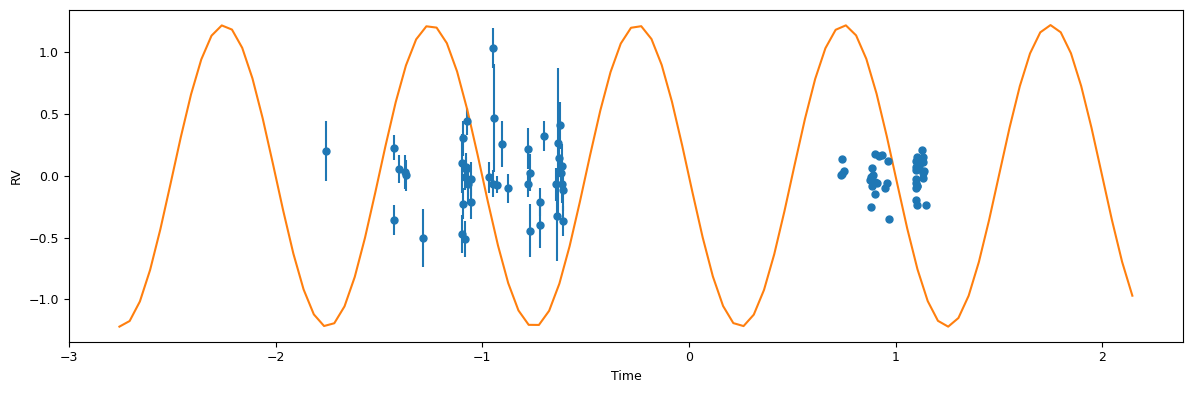

In [171]:
def initialize_model():
    time_base = 0
    params = radvel.Parameters(1,basis='per tc secosw sesinw logk') # number of planets = 2
    params['per1'] = radvel.Parameter(value=1)
    params['tc1'] = radvel.Parameter(value=1)
    params['secosw1'] = radvel.Parameter(value=0.01, vary=False)
    params['sesinw1'] = radvel.Parameter(value=0.01, vary=False)
    params['logk1'] = radvel.Parameter(value=0.2)

    mod = radvel.RVModel(params, time_base=time_base)
    
    # mod.params['dvdt'] = radvel.Parameter(value=-0.02, vary=False)
    # mod.params['curv'] = radvel.Parameter(value=0.01, vary=False)
    
    return mod

def plot_results(like):
    fig = plt.figure(figsize=(12,4))
    fig = plt.gcf()
    fig.set_tight_layout(True)
    plt.errorbar(
        like.x, like.model(t)+like.residuals(),
        yerr=like.yerr, fmt='o'
        )
    plt.plot(ti, like.model(ti))
    plt.xlabel('Time')
    plt.ylabel('RV')
    plt.draw()
    
t = np.array(time)
vel = np.array(residuals)
errvel = rv_err
ti = np.linspace(t[0]-1,t[-1]+1,100)

mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)
like.params['gamma'] = radvel.Parameter(value=0.1, vary=False, linear=True)
like.params['jit'] = radvel.Parameter(value=1.0, vary=False)

# like.params['secosw1'].vary = False
# like.params['sesinw1'].vary = False
# like.params['per1'].vary = True
# like.params['tc1'].vary = True
print(like)

plt.figure()
plot_results(like)

parameter                     value      vary
per1                      0.0130862       True
tc1                       0.0262683       True
secosw1                        0.01      False
sesinw1                        0.01      False
logk1                      -2.46192       True
gamma                     0.0120952      False
jit                               1      False
tp1                       0.0246331           
e1                           0.0002           
w1                         0.785398           
k1                        0.0852709           

Priors
------


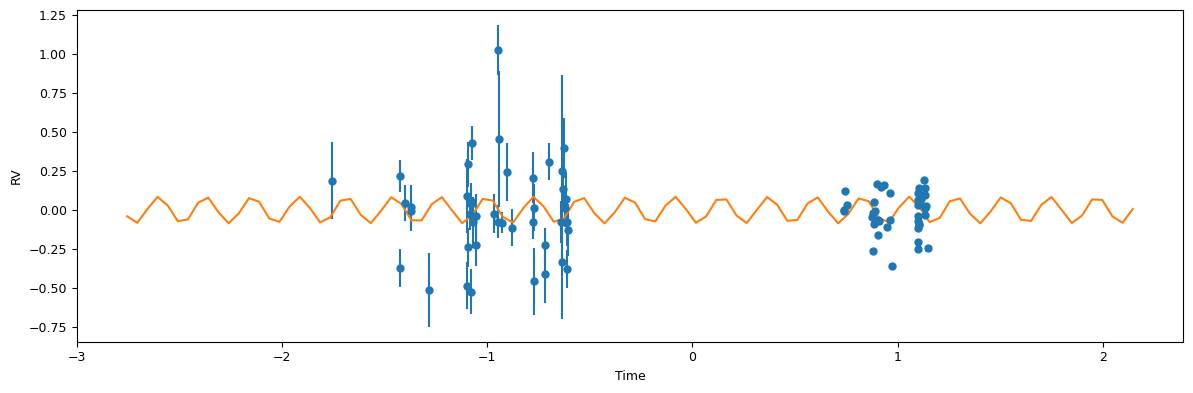

In [178]:
post = radvel.posterior.Posterior(like)
# post.priors += [radvel.prior.Gaussian( 'jit', np.log(3), 0.5)]
# post.priors += [radvel.prior.Gaussian( 'logk1', np.log(1), np.log(3))]
# post.priors += [radvel.prior.Gaussian( 'gamma', 0, 10)]
# post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]

res  = optimize.minimize(
    post.neglogprob_array,     # objective function is negative log likelihood
    post.get_vary_params(),    # initial variable parameters
    method='Nelder-Mead',           # Powell also works
    )

plot_results(like)             # plot best fit model
print(post)

In [104]:
sampler2 = gp.run_mcmc(
    nwalkers=1000, niterations=500, 
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}, 
    initial_theta={key: value for key, value in zip(gp.model_params.keys(), result.x)}
)

  0%|          | 0/500 [00:00<?, ?it/s]/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 15%|█▍        | 73/500 [00:07<00:50,  8.43it/s]Traceback (most recent call last):
  File "/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 591, in log_posterior
    return -np.inf
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 566, in log_likelihood
    for i, kernel in enumerate(self.kernels):
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 129, in compute_kernel
    tau = np.subtract.outer(x1, x2)  # pairwise differences
KeyboardInterrupt
 15%|█▍        | 

emcee: Exception while calling your likelihood function:
  params: [1.06979897 0.92921648 1.04466093 0.12341429 0.77366952 0.53750517]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

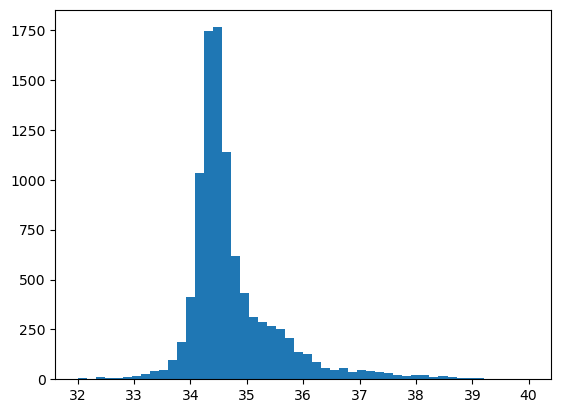

[34.72486004] [432.48084755]
-61.44683040125079
-7.874025492992452
-39.47379728508744


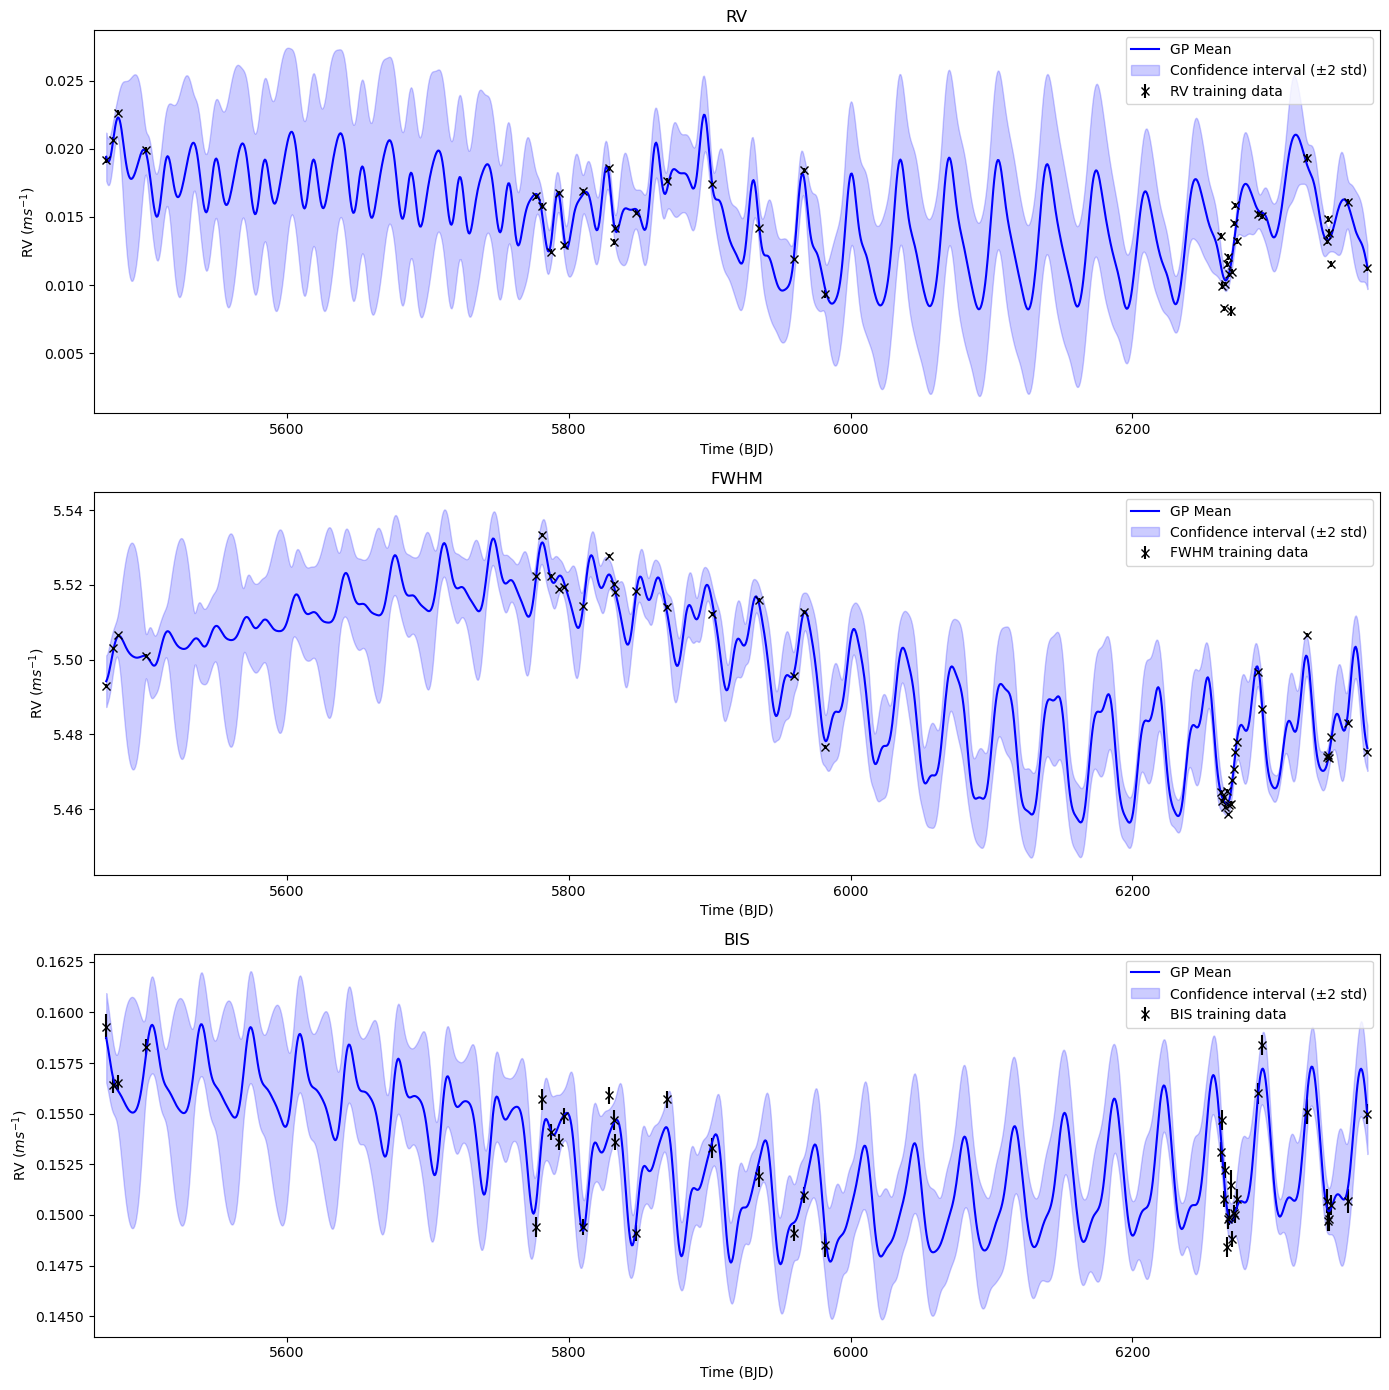

In [95]:
np.random.seed(42)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=1)
result = gp.fit(
    bounds={'stellar_P': (21, 41) / time_scaler.scale_, 'p1_lsp': (1e-5, None)}
)
print(
    gp.model_params['stellar_P'] * time_scaler.scale_,
    gp.model_params['p1_P'] * time_scaler.scale_,
)
fig = triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)
plt.savefig('./1planets.png')
plt.show()

-61.44683040125079


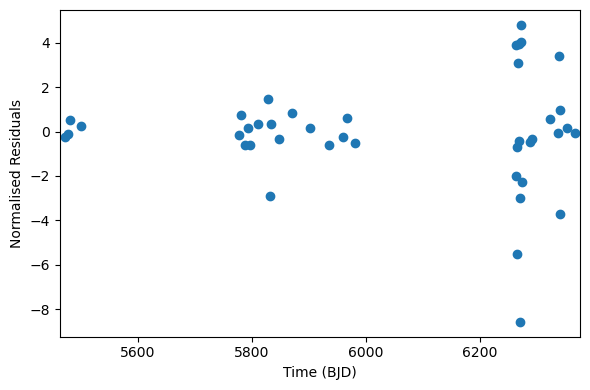

In [81]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)

In [82]:
gp.model_params

{'stellar_amp': 1.2576414387502863,
 'fwhm_amp': 0.7729053571530025,
 'bis_amp': 1.084728680958066,
 'stellar_P': 0.12326757081723634,
 'stellar_lsp': 0.7624448325934828,
 'stellar_lse': 0.7226393233290596,
 'p1_amp': 0.702679569641256,
 'p1_P': 1.535236238058039,
 'p1_lsp': 0.24051263223840186}

In [105]:
sampler2 = gp.run_mcmc(
    nwalkers=1000, niterations=1000, 
    bounds={'stellar_P': (21, 41) / time_scaler.scale_, 'p1_lsp': (1e-5, None)},
    initial_theta={key: value for key, value in zip(gp.model_params.keys(), result.x)}
)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 65%|██████▍   | 647/1000 [01:29<00:52,  6.74it/s]Traceback (most recent call last):
  File "/Users/adnansiddiquei/miniconda3/envs/as3438_exo/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 591, in log_posterior
    return -np.inf
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 567, in log_likelihood
    loglikelihood += (
  File "/Users/adnansiddiquei/Desktop/Cambridge/Exoplanets/as3438/src/q2/utils.py", line 282, in compute_loglikelihood
    gof = np.dot(y, spl.cho_solve((factor, flag), y))
  File "/Users/adnansiddiquei/miniconda3/envs/as3438_e

emcee: Exception while calling your likelihood function:
  params: [2.29995605 0.63575406 1.5549186  0.12382374 0.62088066 0.77561409]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [87]:
# Extract the samples
samples = sampler2.get_chain(discard=200, thin=10, flat=True)
samples[:, 0] = rv_scaler.inverse_transform(samples[:, 0].reshape(-1, 1)).ravel()
samples[:, 1] = fwhm_scaler.inverse_transform(samples[:, 1].reshape(-1, 1)).ravel()
samples[:, 2] = bis_scaler.inverse_transform(samples[:, 2].reshape(-1, 1)).ravel()
samples[:, 3] = samples[:, 3] * time_scaler.scale_
samples[:, 4] = samples[:, 4] * time_scaler.scale_
samples[:, 5] = samples[:, 5] * time_scaler.scale_
samples[:, 6] = rv_scaler.inverse_transform(samples[:, 6].reshape(-1, 1)).ravel()
samples[:, 7] = samples[:, 7] * time_scaler.scale_
samples[:, 8] = samples[:, 8] * time_scaler.scale_

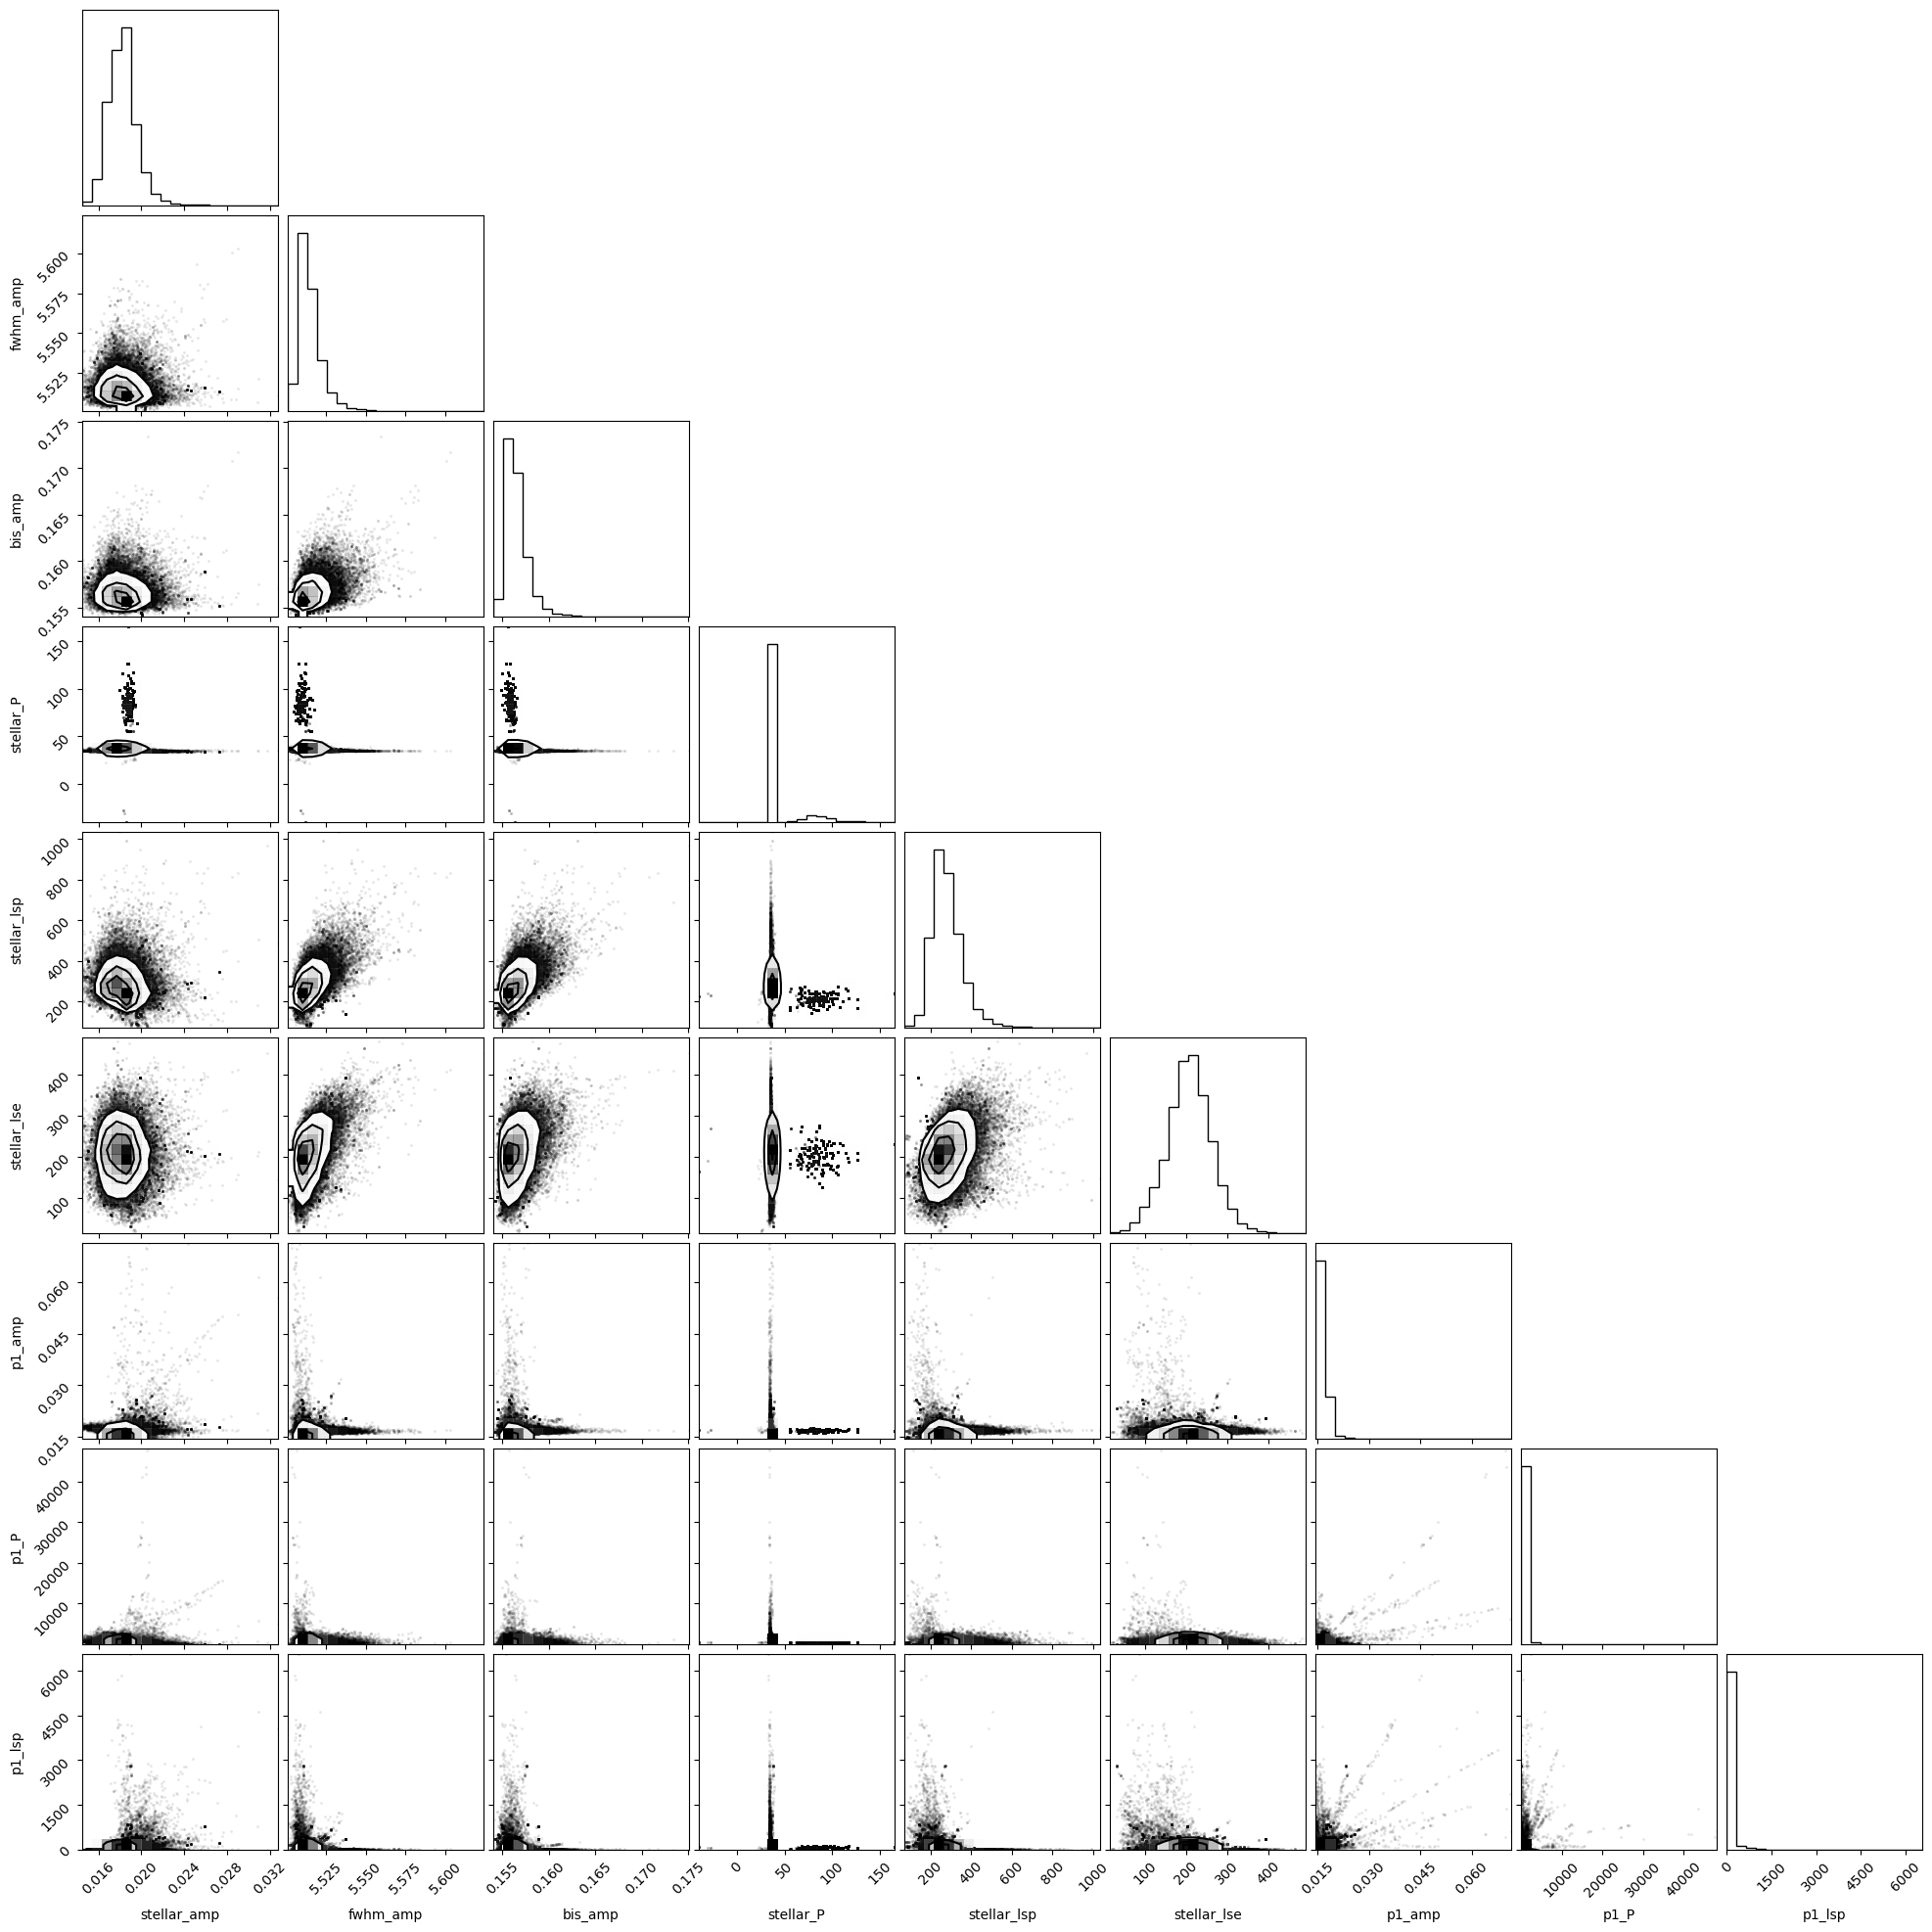

In [88]:
labels = gp.params_keys
figure = corner.corner(samples, labels=labels, truths=None, ranges=[
    None, None, None, (100, 101), None, None
])
# axes = np.array(figure.axes).reshape((6, 6))
# axes[3, 3].set_xlim(0, 50)
plt.show()

[35.01572862] [272.32122012] [419.24316833]
-42.29095516696552
-8.019341276492323
-38.62096131243936


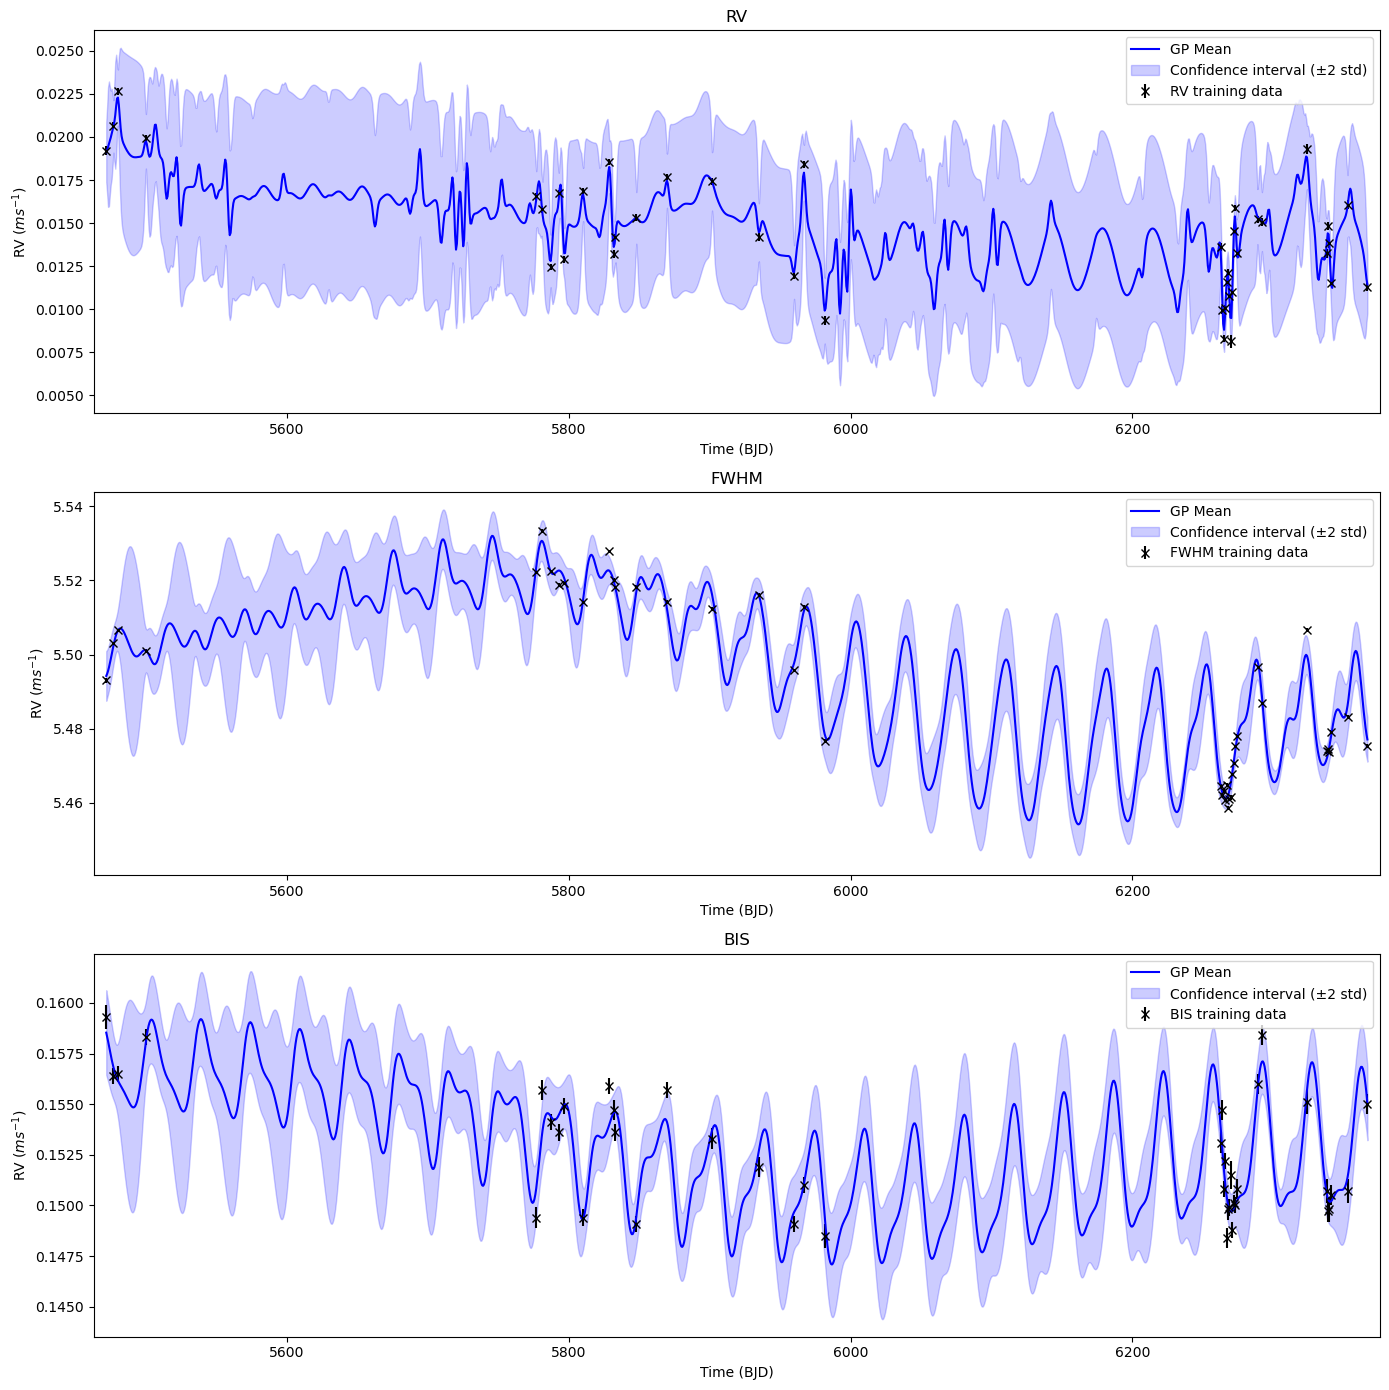

In [96]:
np.random.seed(44)
gp = StellarAndPlanetGP(time, y, y_err, num_planets=2)
gp.fit(
    bounds={'stellar_P': (21, 41) / time_scaler.scale_}
)
print(
    gp.model_params['stellar_P'] * time_scaler.scale_,
    gp.model_params['p1_P'] * time_scaler.scale_,
    gp.model_params['p2_P'] * time_scaler.scale_,
)
fig = triple_plot(gp.kernels, time, y, y_err, time_scaler, y_scalers)
plt.savefig('./2planets.png')
plt.show()

-42.58039421446922


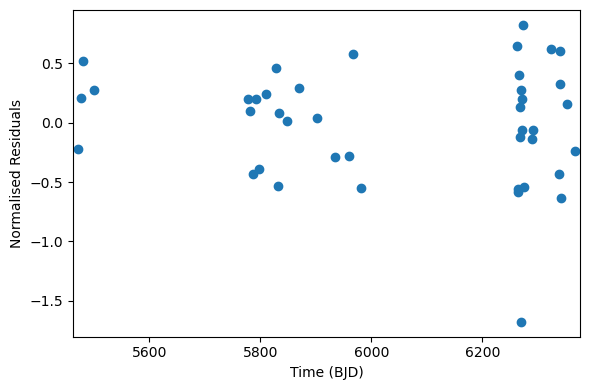

In [53]:
residual_plot(gp.kernels[0], time, rv, rv_err, time_scaler)